In [14]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed for reproducibility (optional)
# np.random.seed(111)

[ 4.79445923 -0.99663413]
-0.9966341268231197


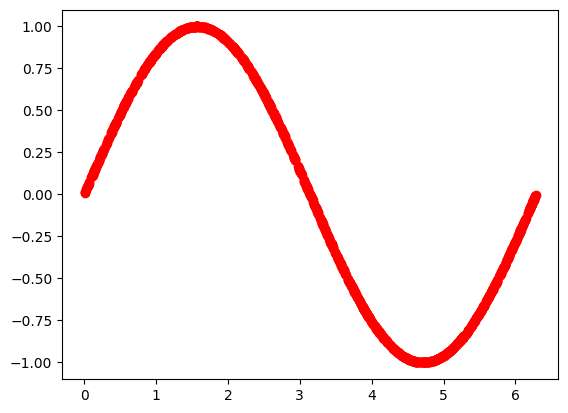

In [15]:
train_data_length = 1024

train_data = np.zeros((train_data_length, 2))

# Random value from 0 to 2pi for x data
train_data[:, 0] = np.random.uniform(0, 2 * math.pi, train_data_length)

# Sin value for y data
train_data[:, 1] = np.sin(train_data[:, 0])

train_set = np.array([
    (train_data[i][0], train_data[i][1]) for i in range(train_data_length)
])

print(train_set[0])
print(np.sin(train_set[0][0]))
# Plot the data
plt.plot(train_data[:, 0], train_data[:, 1], 'ro')


In [16]:
import random
class CustomDataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(dataset)
        self.indices = list(range(self.num_samples))
        self.current_index = 0

        if self.shuffle:
            random.shuffle(self.indices)

    def __iter__(self):
        return CustomDataLoaderIterator(self)

class CustomDataLoaderIterator:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.current_index = 0

    def __next__(self):
        if self.current_index >= self.dataloader.num_samples:
            raise StopIteration

        batch_indices = self.dataloader.indices[self.current_index:self.current_index + self.dataloader.batch_size]
        batch_data = [self.dataloader.dataset[i] for i in batch_indices]

        self.current_index += self.dataloader.batch_size

        return batch_data


In [17]:
train_loader = CustomDataLoader(train_set, batch_size=32, shuffle=True)

for n, real_sample in enumerate(train_loader):
    print(real_sample)
    print(len(real_sample))
    break

[array([ 6.10876171, -0.17354051]), array([1.57985337, 0.99995899]), array([ 6.2013066 , -0.08178725]), array([1.35594957, 0.97700908]), array([0.54506567, 0.51847425]), array([ 5.47951219, -0.71991033]), array([3.10716365, 0.0344222 ]), array([3.08819127, 0.05337601]), array([ 5.51041322, -0.69812267]), array([ 5.98615571, -0.29268117]), array([1.92760857, 0.93701503]), array([ 5.39042479, -0.77880629]), array([ 4.48201221, -0.97358043]), array([1.16412581, 0.9184429 ]), array([ 3.46773634, -0.32039239]), array([ 3.16502417, -0.02342938]), array([2.02873558, 0.89696546]), array([1.53619922, 0.99940158]), array([ 5.28371992, -0.84118201]), array([1.18691374, 0.92721751]), array([ 3.38972744, -0.2455963 ]), array([ 4.90343367, -0.9818064 ]), array([0.58914065, 0.55564675]), array([ 5.67974828, -0.56747583]), array([ 5.26351171, -0.85193715]), array([ 4.12321668, -0.83140089]), array([ 4.56232721, -0.98876184]), array([2.52339418, 0.57956799]), array([ 3.40937342, -0.26459195]), array([ 

In [18]:
import sys
sys.path.append('..')
from common import functions
from common import layers
from collections import OrderedDict
import pickle

# We are going to create Discriminator with MLP
# input node number is the number of features that you would like to consider
class Discriminator:
    def __init__(self, input_node_num, weight_init_std, hidden_node_num1=256,\
                  hidden_node_num2=128, hidden_node_num3=64,\
                  output_node_num=1):
        self.input_node_num = input_node_num
        self.hidden_node_num1 = hidden_node_num1
        self.hidden_node_num2 = hidden_node_num2
        self.hidden_node_num3 = hidden_node_num3
        self.output_node_num = output_node_num

        # Initialize weights

        # Initialize weights
        self.params = {}
        # For graph value, the input node number is 2
        self.params['W1'] = weight_init_std * np.random.randn(self.input_node_num, self.hidden_node_num1)
        self.params['b1'] = np.zeros(self.hidden_node_num1)

        self.params['W2'] = weight_init_std * np.random.randn(self.hidden_node_num1, self.hidden_node_num2)
        self.params['b2'] = np.zeros(self.hidden_node_num2)

        self.params['W3'] = weight_init_std * np.random.randn(self.hidden_node_num2, self.hidden_node_num3)
        self.params['b3'] = np.zeros(self.hidden_node_num3)

        self.params['W4'] = weight_init_std * np.random.randn(self.hidden_node_num3, self.output_node_num)
        self.params['b4'] = np.zeros(self.output_node_num)

        self.layers = OrderedDict()
        # In discriminator, to train the discriminator, we put in the x data and the y data 
        # Since input is x and y data, the input node number is 2
        self.layers['Affine1'] = layers.Affine(self.params['W1'], self.params['b1']) # 2 -> 256
        self.layers['Reul1'] = layers.Relu()
        self.layers['Dropout1'] = layers.Dropout(0.3)

        self.layers['Affine2'] = layers.Affine(self.params['W2'], self.params['b2']) # 256 -> 128
        self.layers['Reul2'] = layers.Relu()
        self.layers['Dropout2'] = layers.Dropout(0.3)

        self.layers['Affine3'] = layers.Affine(self.params['W3'], self.params['b3']) # 128 -> 64
        self.layers['Reul3'] = layers.Relu()
        self.layers['Dropout3'] = layers.Dropout(0.3)

        self.layers['Affine4'] = layers.Affine(self.params['W4'], self.params['b4']) # 64 -> 1
        self.lastLayer = layers.Sigmoid()

    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        x = self.lastLayer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        # t is the real data
        # We will have the real loss function outside of the discriminator
        return self.lastLayer.forward(y)

    # def backward(self, ):

    
    def accuracy(self, x, t):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        y = self.predict(x)
        # y is the predicted data
        # We will have the real loss function outside of the discriminator
        y = np.argmax(y, axis=1)
        acc = np.sum(y == t) / float(x.shape[0])
        return acc
    
    def backward(self, final_loss):
        # the final loss is the loss function result from outside
        # for discriminator, we have to use the binary cross entropy loss function
        dout = final_loss
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        
        # Set gradients
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db

        return grads, dout

    def zero_grad(self):
        self.layers['Affine1'].dW = np.zeros((self.input_node_num, self.hidden_node_num1))
        self.layers['Affine1'].db = np.zeros(self.hidden_node_num1)

        self.layers['Affine2'].dW = np.zeros((self.hidden_node_num1, self.hidden_node_num2))
        self.layers['Affine2'].db = np.zeros(self.hidden_node_num2)

        self.layers['Affine3'].dW = np.zeros((self.hidden_node_num2, self.hidden_node_num3))
        self.layers['Affine3'].db = np.zeros(self.hidden_node_num3)

        self.layers['Affine4'].dW = np.zeros((self.hidden_node_num3, self.output_node_num))
        self.layers['Affine4'].db = np.zeros(self.output_node_num)
    
    def set_params(self, params):
        self.params = params
        self.layers['Affine1'].W = self.params['W1']
        self.layers['Affine1'].b = self.params['b1']

        self.layers['Affine2'].W = self.params['W2']
        self.layers['Affine2'].b = self.params['b2']

        self.layers['Affine3'].W = self.params['W3']
        self.layers['Affine3'].b = self.params['b3']

        self.layers['Affine4'].W = self.params['W4']
        self.layers['Affine4'].b = self.params['b4']

    
    def save_params(self, file_name="discriminator_params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    def load_params(self, file_name="discriminator_params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
        self.layers['Affine1'].W = self.params['W1']
        self.layers['Affine1'].b = self.params['b1']

        self.layers['Affine2'].W = self.params['W2']
        self.layers['Affine2'].b = self.params['b2']

        self.layers['Affine3'].W = self.params['W3']
        self.layers['Affine3'].b = self.params['b3']

        self.layers['Affine4'].W = self.params['W4']
        self.layers['Affine4'].b = self.params['b4']
        




In [19]:
class Generator():
    def __init__(self, input_node_num, weight_init_std, hidden_node_num1=16,\
                  hidden_node_num2=32,\
                  output_node_num=2):
        self.input_node_num = input_node_num
        self.hidden_node_num1 = hidden_node_num1
        self.hidden_node_num2 = hidden_node_num2
        self.output_node_num = output_node_num

        # Initialize weights
        self.params = {}
        # For graph value, the input node number is 2
        self.params['W1'] = weight_init_std * np.random.randn(self.input_node_num, self.hidden_node_num1)
        self.params['b1'] = np.zeros(self.hidden_node_num1)

        self.params['W2'] = weight_init_std * np.random.randn(self.hidden_node_num1, self.hidden_node_num2)
        self.params['b2'] = np.zeros(self.hidden_node_num2)

        self.params['W3'] = weight_init_std * np.random.randn(self.hidden_node_num2, self.output_node_num)
        self.params['b3'] = np.zeros(self.output_node_num)

        self.layers = OrderedDict()

        # In generator, to train the generator, we put in the x data and the y data
        # Since input is x and y data, the input node number is 2
        self.layers['Affine1'] = layers.Affine(self.params['W1'], self.params['b1']) # 2 -> 16
        self.layers['Reul1'] = layers.Relu()

        self.layers['Affine2'] = layers.Affine(self.params['W2'], self.params['b2']) # 16 -> 32
        self.layers['Reul2'] = layers.Relu()

        self.layers['Affine3'] = layers.Affine(self.params['W3'], self.params['b3']) # 32 -> 2
        # self.lastLayer = layers.Tanh()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        # x = self.lastLayer.forward(x)
        return x
    

    def loss(self, x, t):
        y = self.predict(x)
        # We will have the real loss function outside of the generator
        return y

    def backward(self, final_loss):
        # the final loss is the loss function result from outside
        # for discriminator, we have to use the binary cross entropy loss function
        dout = final_loss
        # dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)
        
        # Set gradients
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads, dout

    # gradient decides the direction of the weight update
    def zero_grad(self):
        self.layers['Affine1'].dW = np.zeros((self.input_node_num, self.hidden_node_num1))
        self.layers['Affine1'].db = np.zeros(self.hidden_node_num1)

        self.layers['Affine2'].dW = np.zeros((self.hidden_node_num1, self.hidden_node_num2))
        self.layers['Affine2'].db = np.zeros(self.hidden_node_num2)

        self.layers['Affine3'].dW = np.zeros((self.hidden_node_num2, self.output_node_num))
        self.layers['Affine3'].db = np.zeros(self.output_node_num)
    
    # parameters is the weight and bias
    def set_params(self, params):
        self.params = params
        self.layers['Affine1'].W = self.params['W1']
        self.layers['Affine1'].b = self.params['b1']

        self.layers['Affine2'].W = self.params['W2']
        self.layers['Affine2'].b = self.params['b2']

        self.layers['Affine3'].W = self.params['W3']
        self.layers['Affine3'].b = self.params['b3']
    
    def save_params(self, file_name="generator_params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    def load_params(self, file_name="generator_params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
        self.layers['Affine1'].W = self.params['W1']
        self.layers['Affine1'].b = self.params['b1']

        self.layers['Affine2'].W = self.params['W2']
        self.layers['Affine2'].b = self.params['b2']

        self.layers['Affine3'].W = self.params['W3']
        self.layers['Affine3'].b = self.params['b3']

        

In [20]:
discriminator = Discriminator(input_node_num=2, weight_init_std=0.01)
generator = Generator(input_node_num=2, weight_init_std=0.01)

In [29]:
from common.functions import binary_cross_entropy_error, binary_cross_entropy_gradient
from common.layers import BCELoss
from common.optimizer import Adam


iters_num = 300
batch_size = 32
train_data_length = 1024
learning_rate = 0.001
weight_init_std = 0.01

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_data_length / batch_size, 1)

discriminator_optimizer = Adam(lr=learning_rate)
generator_optimizer = Adam(lr=learning_rate)


for epoch in range(iters_num):
    for n, real_samples in enumerate(train_loader):
    # use the previously created train_set to train the discriminator
    # choose random data from the train_set
    # for n, real_samples in enumerate(train_set):  
        real_samples_labels = np.ones((batch_size, 1)) # the real sample label is 1


        latent_space_samples = np.random.randn(batch_size, 2)
        generated_samples = generator.predict(latent_space_samples)
        generated_samples_labels = np.zeros((batch_size, 1)) # since we are generating fake data, the label is 1
        # 0 means 'False' in the discriminator
        # We also compare the generated data with the real data
        all_samples = np.concatenate((real_samples, generated_samples), axis=0)

        # the batch mask is the real data, so the label is 1!
        # the generated samples is the fake data, so the label is 0!
        # all_samples = np.concatenate((x_batch, generated_samples), axis=0)
        
        # real sample labels are all 1
        # generated sample labels are all 0
        all_samples_labels = np.concatenate((real_samples_labels, generated_samples_labels), axis=0)
        # we concatenate the real sample labels and the fake sample labels

        # Update parameters of discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator.predict(all_samples)
        # We calculate the loss externally!
        bce_loss_discriminator = BCELoss()
        loss_discriminator = bce_loss_discriminator.forward(output_discriminator, all_samples_labels)
        loss_discriminator_gradient = bce_loss_discriminator.backward()

        grads_discriminator = discriminator.backward(loss_discriminator_gradient)[0]
        discriminator_optimizer.update(discriminator.params, grads_discriminator)

        # We generate new data
        latent_space_samples = np.random.randn(batch_size, 2)
        generated_samples = generator.predict(latent_space_samples)
        output_discriminator_generated = discriminator.predict(generated_samples)
        # loss_function = BCELoss()
        # loss_generator = loss_function.forward(output_discriminator_generated, real_samples_labels)
        # loss_generator = BCELoss()
        # loss_generator.forward(output_discriminator_generated, real_samples_labels)
        bce_loss_generator = BCELoss()
        loss_generator = bce_loss_generator.forward(output_discriminator_generated, real_samples_labels)
        loss_generator_gradient = bce_loss_generator.backward()
        # we get the imagined input from discriminator
        backwarded_discriminator = discriminator.backward(loss_generator_gradient)[1] 



        # loss_gradient = binary_cross_entropy_gradient(output_discriminator_generated, real_samples_labels)
        discriminator.zero_grad()
        generator.zero_grad()
        grads_generator = generator.backward(backwarded_discriminator)[0]
        generator_optimizer.update(generator.params, grads_generator)

        if epoch % 10 == 0 and n == batch_size - 1:
            print("Epoch:", epoch)
            print("Discriminator Loss:", loss_discriminator)
            print("Generator Loss:", loss_generator)
            print("")
        

Epoch: 0
Discriminator Loss: 0.6985405362039824
Generator Loss: 0.780711493911391

Epoch: 10
Discriminator Loss: 0.6583599732383987
Generator Loss: 0.969481691881971

Epoch: 20
Discriminator Loss: 0.6889083949636652
Generator Loss: 0.8448147491974016

Epoch: 30
Discriminator Loss: 0.6750847269195648
Generator Loss: 0.8935481173100218

Epoch: 40
Discriminator Loss: 0.5527364729069199
Generator Loss: 0.8139915422323655

Epoch: 50
Discriminator Loss: 0.492664915940702
Generator Loss: 1.194877649148797

Epoch: 60
Discriminator Loss: 0.6275974608335331
Generator Loss: 0.8229246779787212

Epoch: 70
Discriminator Loss: 0.6161622832760725
Generator Loss: 0.8035911636071775

Epoch: 80
Discriminator Loss: 0.41880838871667964
Generator Loss: 1.4199368694047625

Epoch: 90
Discriminator Loss: 0.6350814196372236
Generator Loss: 0.8898747344915225

Epoch: 100
Discriminator Loss: 0.6484668198756294
Generator Loss: 0.9775115866195727

Epoch: 110
Discriminator Loss: 0.570026659445821
Generator Loss: 0.9

In [30]:
latent_space_samples = np.random.randn(100, 2)

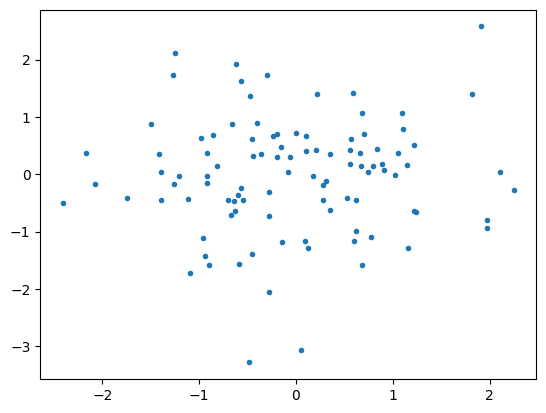

In [31]:
plt.plot(latent_space_samples[:, 0], latent_space_samples[:, 1], ".")

In [32]:
# Now our trained generator will generate 100 samples that are able to fool the discriminator
generated_samples = generator.predict(latent_space_samples)

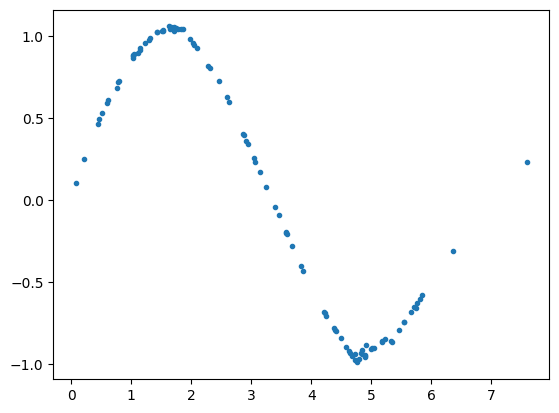

In [33]:
generated_samples = generated_samples
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

In [34]:
# We will save the parameters of the discriminator and the generator
discriminator.save_params()
generator.save_params()